In [6]:
# Setup, Imports, and Configuration 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import os
import matplotlib.pyplot as plt
import numpy as np

# Configuration 
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png')

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, class_dirs, transform=None):
        self.transform = transform
        self.class_dirs = class_dirs
        self.classes = list(class_dirs.keys())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = self._make_dataset()
    def _make_dataset(self):
        instances = []
        for class_name, dir_path in self.class_dirs.items():
            class_idx = self.class_to_idx[class_name]
            if not os.path.isdir(dir_path): continue
            for fname in sorted(os.listdir(dir_path)):
                if fname.lower().endswith(IMG_EXTENSIONS):
                    path = os.path.join(dir_path, fname)
                    item = (path, class_idx)
                    instances.append(item)
        return instances
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        from PIL import Image
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform: image = self.transform(image)
        return image, label

# Main project parameters
DATA_DIR = "/kaggle/input/deepstroke/DeepStroke1_Data/"
IMAGE_SIZE = 128
CHANNELS_IMG = 3
LATENT_DIM = 128
BATCH_SIZE = 512
LR = 0.001
NUM_EPOCHS = 75

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Successfully loaded 13333 images from all classes.


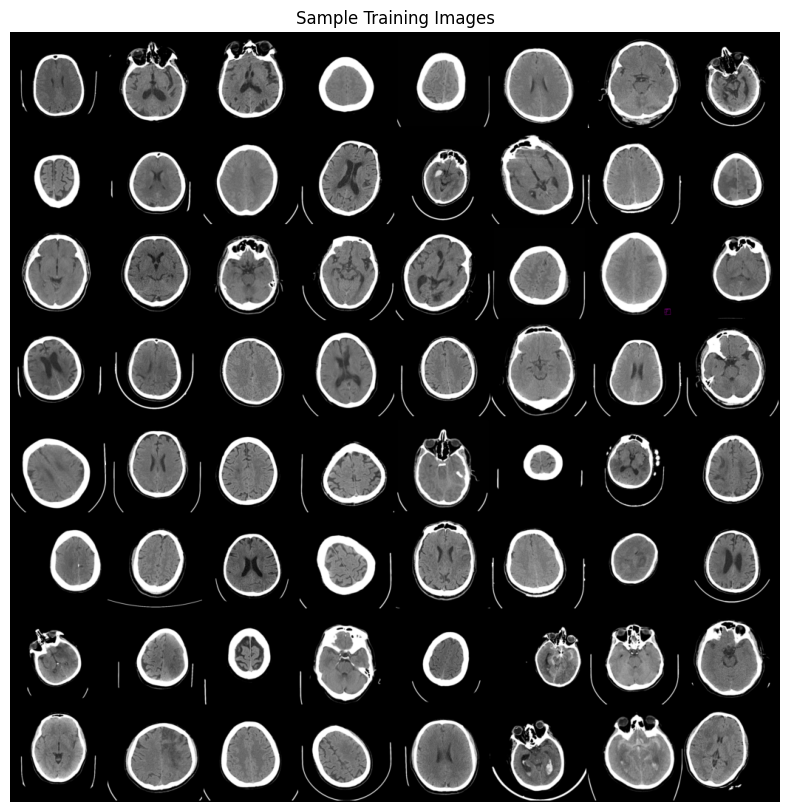

In [7]:
# Data Loading 

# Define the transformations. For VAE with BCE loss, we normalize to [0, 1].
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(), # This automatically scales images to [0, 1]
])

# Define the directories we want to use
class_directories = {
    'Non-Ischaemic': os.path.join(DATA_DIR, "Non-Ischaemic"),
    'Ischaemic': os.path.join(DATA_DIR, "Ischaemic"),
    'Hemoraj': os.path.join(DATA_DIR, "Hemoraj")
}

# Create a single dataset containing ALL images
full_dataset = CustomImageDataset(class_dirs=class_directories, transform=transform)

# Create the DataLoader
# We don't need to separate the data, we train the VAE on everything.
train_dataloader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Successfully loaded {len(full_dataset)} images from all classes.")

# Let's visualize a batch 
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [10]:
# VAE Model and Loss Function 
import torch.nn as nn

BASE_CHANNELS = 128

class VAE(nn.Module):
    def __init__(self, channels_img=3, latent_dim=128): 
        super(VAE, self).__init__()
        # Encoder
        self.encoder_net = nn.Sequential(
            # Input: 128x128
            nn.Conv2d(channels_img, BASE_CHANNELS, 4, 2, 1), # 128x64x64
            nn.ReLU(True),
            nn.Conv2d(BASE_CHANNELS, BASE_CHANNELS * 2, 4, 2, 1), # 256x32x32
            nn.ReLU(True),
            nn.Conv2d(BASE_CHANNELS * 2, BASE_CHANNELS * 4, 4, 2, 1), # 512x16x16
            nn.ReLU(True),
            nn.Conv2d(BASE_CHANNELS * 4, BASE_CHANNELS * 8, 4, 2, 1), # 1024x8x8
            nn.ReLU(True),
            nn.Flatten(),
        )
        self.fc_mu = nn.Linear(BASE_CHANNELS * 8 * 8 * 8, latent_dim)
        self.fc_log_var = nn.Linear(BASE_CHANNELS * 8 * 8 * 8, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, BASE_CHANNELS * 8 * 8 * 8)
        self.decoder_net = nn.Sequential(
            # Reshape to 1024x8x8
            nn.ConvTranspose2d(BASE_CHANNELS * 8, BASE_CHANNELS * 4, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(BASE_CHANNELS * 4, BASE_CHANNELS * 2, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(BASE_CHANNELS * 2, BASE_CHANNELS, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(BASE_CHANNELS, channels_img, 4, 2, 1),
            nn.Sigmoid(), # Sigmoid for [0, 1] output
        )

    def encode(self, x):
        x = self.encoder_net(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, BASE_CHANNELS * 8, 8, 8) # Reshape to a starting feature map
        return self.decoder_net(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var

# The VAE Loss Function
def vae_loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, IMAGE_SIZE*IMAGE_SIZE*CHANNELS_IMG),
                                             x.view(-1, IMAGE_SIZE*IMAGE_SIZE*CHANNELS_IMG),
                                             reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

print(f"VAE Model and Loss Function re-defined with BASE_CHANNELS = {BASE_CHANNELS}.")

VAE Model and Loss Function re-defined with BASE_CHANNELS = 128.


In [13]:
# Suppress DataLoader Warnings 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.data.dataloader")
warnings.filterwarnings("ignore", message="can only test a child process")

print("DataLoader warnings will be suppressed.")

DataLoader warnings will be suppressed.


Using 2 GPUs!
Starting VAE Training...


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [1/75] finished, Average Loss: 23731.2349


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [2/75] finished, Average Loss: 18228.2659


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [3/75] finished, Average Loss: 17024.6168


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [4/75] finished, Average Loss: 15756.6552


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [5/75] finished, Average Loss: 15154.6293


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [6/75] finished, Average Loss: 14744.0717


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [7/75] finished, Average Loss: 14342.2257


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [8/75] finished, Average Loss: 13757.0284


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [9/75] finished, Average Loss: 13570.2500


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [10/75] finished, Average Loss: 13451.3253


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [11/75] finished, Average Loss: 13264.5285


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [12/75] finished, Average Loss: 13103.5947


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [13/75] finished, Average Loss: 13088.6539


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [14/75] finished, Average Loss: 12907.8279


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [15/75] finished, Average Loss: 12793.4706


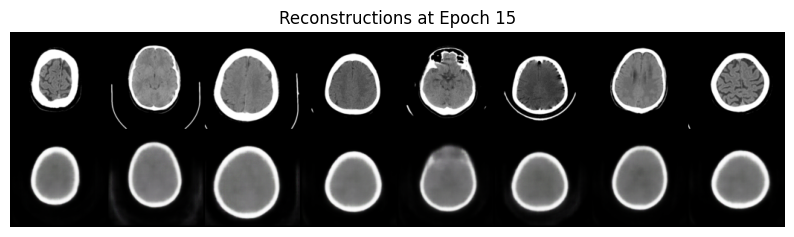

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [16/75] finished, Average Loss: 12675.2254


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [17/75] finished, Average Loss: 13049.8724


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [18/75] finished, Average Loss: 12466.1320


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [19/75] finished, Average Loss: 12321.0717


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [20/75] finished, Average Loss: 12207.8883


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [21/75] finished, Average Loss: 12127.4417


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [22/75] finished, Average Loss: 12090.3884


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [23/75] finished, Average Loss: 11948.5667


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [24/75] finished, Average Loss: 12076.5952


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [25/75] finished, Average Loss: 11812.6094


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [26/75] finished, Average Loss: 11740.2750


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [27/75] finished, Average Loss: 11673.1967


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [28/75] finished, Average Loss: 11710.7855


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [29/75] finished, Average Loss: 11601.5398


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [30/75] finished, Average Loss: 11508.7066


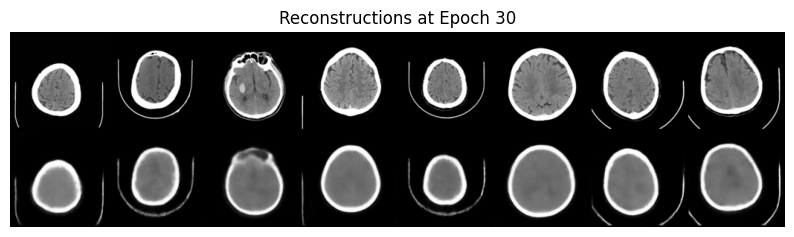

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [31/75] finished, Average Loss: 11446.0667


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [32/75] finished, Average Loss: 11384.9759


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [33/75] finished, Average Loss: 11356.7298


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [34/75] finished, Average Loss: 11414.7688


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [35/75] finished, Average Loss: 11313.7003


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [36/75] finished, Average Loss: 11330.9344


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [37/75] finished, Average Loss: 11173.8896


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [38/75] finished, Average Loss: 11155.4884


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [39/75] finished, Average Loss: 11155.7877


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [40/75] finished, Average Loss: 11107.2967


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [41/75] finished, Average Loss: 11140.5434


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [42/75] finished, Average Loss: 11034.7466


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [43/75] finished, Average Loss: 11035.0672


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [44/75] finished, Average Loss: 10981.2074


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [45/75] finished, Average Loss: 10966.9563


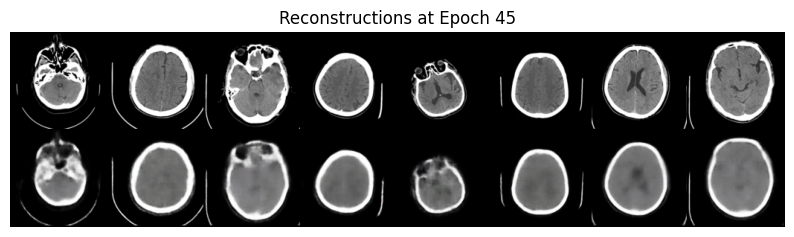

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [46/75] finished, Average Loss: 10962.0885


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [47/75] finished, Average Loss: 10950.7234


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [48/75] finished, Average Loss: 11088.3004


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [49/75] finished, Average Loss: 10908.9459


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [50/75] finished, Average Loss: 10846.1007


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [51/75] finished, Average Loss: 10813.9960


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [52/75] finished, Average Loss: 10813.7821


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [53/75] finished, Average Loss: 11065.6011


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [54/75] finished, Average Loss: 10840.6043


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [55/75] finished, Average Loss: 10770.1595


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [56/75] finished, Average Loss: 10779.4349


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [57/75] finished, Average Loss: 10734.8199


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [58/75] finished, Average Loss: 10776.7475


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [59/75] finished, Average Loss: 10731.9472


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [60/75] finished, Average Loss: 10708.8816


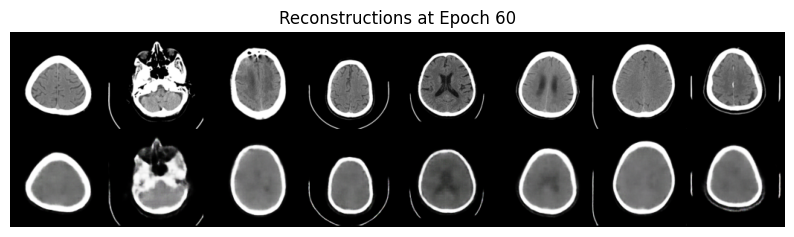

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [61/75] finished, Average Loss: 10720.0407


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [62/75] finished, Average Loss: 10704.1445


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [63/75] finished, Average Loss: 10670.6405


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [64/75] finished, Average Loss: 10670.9344


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [65/75] finished, Average Loss: 10635.5738


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [66/75] finished, Average Loss: 10606.4527


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [67/75] finished, Average Loss: 10624.4025


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [68/75] finished, Average Loss: 10596.1922


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [69/75] finished, Average Loss: 10582.2773


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [70/75] finished, Average Loss: 10568.6667


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [71/75] finished, Average Loss: 10596.2643


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [72/75] finished, Average Loss: 10886.8021


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [73/75] finished, Average Loss: 10608.9011


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [74/75] finished, Average Loss: 10539.6771


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [75/75] finished, Average Loss: 10519.3475


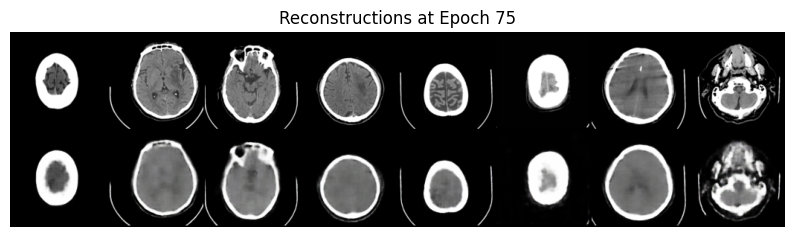


Training Finished.
Model saved to vae_brain_ct.pth


In [14]:
# Training 
from tqdm.notebook import tqdm 
import torch.optim as optim

# Initialize model and optimizer
model = VAE(channels_img=CHANNELS_IMG, latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

print("Starting VAE Training...")
# The main training loop 
for epoch in range(NUM_EPOCHS):
    # Wrap the dataloader with tqdm for a progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)
    loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    
    total_loss = 0
    for batch_idx, (data, _) in loop:
        data = data.to(device)
        
        # Forward pass
        recon_batch, mu, log_var = model(data)
        
        # Calculate loss
        loss = vae_loss_function(recon_batch, data, mu, log_var)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update the progress bar with the current loss
        loop.set_postfix(loss=loss.item() / len(data))

    avg_loss = total_loss / len(train_dataloader.dataset)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] finished, Average Loss: {avg_loss:.4f}')

    # Save a sample reconstruction at the end of some epochs
    if (epoch + 1) % 15 == 0 or epoch == NUM_EPOCHS - 1:
        with torch.no_grad():
            # Get a batch of real images
            real_images = next(iter(train_dataloader))[0].to(device)
            # Generate reconstructions
            reconstructions, _, _ = model(real_images)

            # Concatenate real and reconstructed images for comparison
            comparison = torch.cat([real_images[:8], reconstructions[:8]])
            
            # Save the grid of images
            grid = vutils.make_grid(comparison.cpu(), nrow=8, padding=2, normalize=True)
            plt.figure(figsize=(10,3))
            plt.title(f'Reconstructions at Epoch {epoch+1}')
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis('off')
            plt.show()

print("\nTraining Finished.")
# Save the trained model
torch.save(model.state_dict(), 'vae_brain_ct.pth')
print("Model saved to vae_brain_ct.pth")

--- Performing Latent Space Interpolation ---


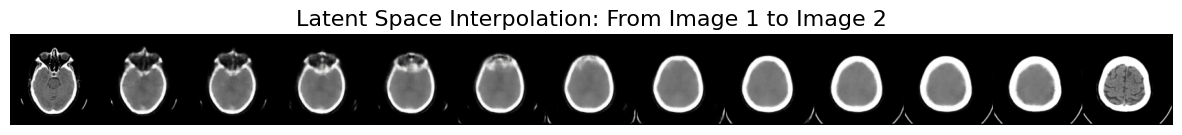

In [15]:
# Latent Space Exploration and Interpolation 

print("--- Performing Latent Space Interpolation ---")

# Ensure model is in eval mode
model.eval()

# Select two images to interpolate between
# Let's grab two images from one batch of our dataloader
images, _ = next(iter(train_dataloader))
img1 = images[0].unsqueeze(0).to(device)
img2 = images[1].unsqueeze(0).to(device)

# Get the latent space representations (mu and log_var) for our two images
with torch.no_grad():
    mu1, log_var1 = model.module.encode(img1) if isinstance(model, nn.DataParallel) else model.encode(img1)
    mu2, log_var2 = model.module.encode(img2) if isinstance(model, nn.DataParallel) else model.encode(img2)
    
    # We use the mean (mu) as the canonical point in the latent space
    z1 = model.module.reparameterize(mu1, log_var1)
    z2 = model.module.reparameterize(mu2, log_var2)

# Create a series of interpolated latent vectors
num_steps = 10 # Number of steps in our animation
interp_z = []
for i in range(num_steps + 1):
    alpha = i / num_steps
    # Linear interpolation: z = (1-alpha)*z1 + alpha*z2
    z = (1 - alpha) * z1 + alpha * z2
    interp_z.append(z)

interp_z = torch.cat(interp_z, dim=0)

# Decode the interpolated latent vectors back into images
with torch.no_grad():
    interp_images = model.module.decode(interp_z).cpu() if isinstance(model, nn.DataParallel) else model.decode(interp_z).cpu()

# Visualize the original, the interpolated sequence, and the target image
# Add the original and target images to the sequence for a complete view
final_sequence = torch.cat([img1.cpu(), interp_images, img2.cpu()], dim=0)

# Display the final animation strip
grid = vutils.make_grid(final_sequence, nrow=num_steps + 3, padding=2, normalize=True)
plt.figure(figsize=(15, 5))
plt.title("Latent Space Interpolation: From Image 1 to Image 2", fontsize=16)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.show()